In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import traceback

import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import string
import shap
import requests
import io

from pandas import Series, DataFrame
from math import radians
from sklearn.metrics.pairwise import haversine_distances

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# First let's load the data and take a look at the first few rows of the weather dataframe to get a feel for the data.

In [5]:
# Downloading the csv file from my GitHub account

weather_url = "https://raw.githubusercontent.com/timshilstone/machine_learning/main/data/weather.csv"
weather_download = requests.get(weather_url).content

# Reading the downloaded content and turning it into a pandas dataframe

weather_df = pd.read_csv(io.StringIO(weather_download.decode('utf-8')))

# Now doing the same for the training data
train_url = "https://raw.githubusercontent.com/timshilstone/machine_learning/main/data/train.csv"
train_download = requests.get(train_url).content
train_df = pd.read_csv(io.StringIO(train_download.decode('utf-8')))

In [4]:
#weather_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/weather.csv')
#train_df = pd.read_csv('/Users/Dreamscape/Documents/Data_Analysis/West Nile Virus Capstone/predict-west-nile-virus/west_nile/input/train.csv')

In [6]:
pd.set_option('display.max_columns', None)

# Cleaning and Transforming the Weather Dataframe

In [7]:
# Right off the bat we can see this dataframe will need quite a bit of cleaning.

In [8]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [9]:
# In the data 'M' stands for missing, so let's convert all instances of this to NaN so we can work with the data.

In [10]:
weather_df.replace('M',np.nan,inplace=True)

In [11]:
# Let's split the date field into it's Year, Month and Day parts and save them each to their own columns.

In [12]:
weather_df[['Year', 'Month', 'Day']] = weather_df['Date'].str.split('-',expand=True)

In [13]:
# By replacing the - values in Sunrise and Sunset we create a forward fill.

In [14]:
weather_df['Sunrise'].replace('-',None, inplace=True)
weather_df['Sunset'].replace('-',None, inplace=True)

In [15]:
# And we can forward fill the Depart field as well to get a value for the second station on the same day.

In [16]:
weather_df['Depart'].fillna(method='ffill',inplace=True)

In [17]:
# Here I'm creating a Temperature range column that is just the difference between the Max and Min temperatures.

In [18]:
weather_df['Trange'] = weather_df['Tmax'] - weather_df['Tmin']

In [19]:
weather_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Trange
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,05,01,33
1,2,2007-05-01,84,52,68,14,51,57,0,3,0448,1849,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,2007,05,01,32
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,05,02,17
3,2,2007-05-02,60,43,52,-3,42,47,13,0,0447,1850,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,2007,05,02,17
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,05,03,20


In [20]:
# Let's take a look at the CodeSum field. Each letters correspond to a different weather pattern. For example
# RA means it rained on that given day, HZ means there was Haze on the given day, etc.

In [21]:
weather_df['CodeSum'].value_counts().head(30)

                   1609
RA                  296
RA BR               238
BR                  110
TSRA RA BR           92
BR HZ                81
RA DZ BR             65
TSRA RA              43
HZ                   39
RA BR HZ             38
TSRA                 34
RA DZ                22
TSRA BR              21
TS TSRA RA BR        19
RA HZ                16
TS RA                13
TSRA RA BR HZ        12
TS TSRA BR           10
TS                   10
DZ BR                10
DZ BR HZ              9
DZ                    8
TSRA BR HZ            8
TS RA BR              8
TS TSRA BR HZ         7
TS TSRA RA            7
TS TSRA               7
RA DZ BR HZ           7
TS BR                 4
TSRA RA BR VCTS       4
Name: CodeSum, dtype: int64

In [22]:
# I'll break down the most frquent codes into their own boolean columns. 

In [23]:
weather_df['Rain'] = weather_df['CodeSum'].str.contains('RA').astype(int)
weather_df['Mist'] = weather_df['CodeSum'].str.contains('BR').astype(int)
weather_df['TSRA'] = weather_df['CodeSum'].str.contains('TSRA').astype(int)
weather_df['Haze'] = weather_df['CodeSum'].str.contains('HZ').astype(int)
weather_df['Drizzle'] = weather_df['CodeSum'].str.contains('DZ').astype(int)
weather_df['Thunderstorm'] = weather_df['CodeSum'].str.contains('TS').astype(int)
weather_df['Local_TS'] = weather_df['CodeSum'].str.contains('VCTS').astype(int)

In [24]:
# Here I see that Depth only contains one value so I drop it from the dataframe.

In [25]:
weather_df['Depth'].value_counts()

0    1472
Name: Depth, dtype: int64

In [26]:
weather_df.drop(['Depth'],axis=1,inplace=True)

In [27]:
# Similar to the Depart column I will forward fill the Snowfall data from station 1 to station 2 
# because they are so close to eachother.

In [28]:
weather_df.SnowFall.fillna(method='ffill',inplace=True)

In [29]:
# Looking at the different values we can see some contain 'T' which corresponds to 'Traces'. Considering 
# the value above that is 0.1 and below it is 0 I'll change this to 0.05 so we can make use of the data.

In [30]:
weather_df.SnowFall.value_counts()

0.0    2918
  T      24
0.1       2
Name: SnowFall, dtype: int64

In [31]:
weather_df.SnowFall =  weather_df.SnowFall.replace('  T',0.05)

In [32]:
weather_df.SnowFall.value_counts()

0.0     2918
0.05      24
0.1        2
Name: SnowFall, dtype: int64

In [33]:
# For the missing valiues in Tavg we can fill this with the average between the Tmax and Tmin.

In [34]:
weather_df.Tavg.fillna((weather_df.Tmax+weather_df.Tmin)/2,inplace=True)

In [35]:
# Similar logic to the Snowfall 'T' values, I'll replace 'T' in the Precip total with the average value above and below 'T'

In [36]:
weather_df.PrecipTotal =  weather_df.PrecipTotal.replace('  T',0.005)

In [37]:
# Wetbulb was stored as a string so let's convert it to a number.

In [38]:
weather_df.WetBulb = pd.to_numeric(weather_df.WetBulb, errors='coerce')

In [39]:
# For this column I'll replace missing values with the mean value across the dataframe.

In [40]:
weather_df.WetBulb.fillna(weather_df.WetBulb.mean(),inplace=True)

In [41]:
# For cool and heat and Precip total I'll fill na values with 0

In [42]:
weather_df.Heat.fillna(0,inplace=True)

In [43]:
weather_df.Cool.fillna(0,inplace=True)

In [44]:
weather_df.PrecipTotal.fillna(0,inplace=True)

In [45]:
# For StnPressure, Sealevel and AvgSpeed I'll transform them to numeric columns and fill nan values with the mean.

In [46]:
weather_df.StnPressure = pd.to_numeric(weather_df.StnPressure,errors='coerce')
weather_df.StnPressure.fillna(weather_df.StnPressure.mean(),inplace=True)

In [47]:
weather_df.SeaLevel = pd.to_numeric(weather_df.SeaLevel,errors='coerce')
weather_df.SeaLevel.fillna(weather_df.SeaLevel.mean(),inplace=True)

In [48]:
weather_df.AvgSpeed = pd.to_numeric(weather_df.AvgSpeed,errors='coerce')
weather_df.AvgSpeed.fillna(weather_df.AvgSpeed.mean(),inplace=True)

In [49]:
# Water only contained one value so I dropped it from the dataframe.

In [50]:
weather_df.drop(['Water1'],axis=1,inplace=True)

In [51]:
weather_df

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS
0,1,2007-05-01,83,50,67,14,51,56.0,0,2,0448,1849,,0.0,0.00,29.10,29.82,1.7,27,9.2,2007,05,01,33,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68,14,51,57.0,0,3,0448,1849,,0.0,0.00,29.18,29.82,2.7,25,9.6,2007,05,01,32,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,51,-3,42,47.0,14,0,0447,1850,BR,0.0,0.00,29.38,30.09,13.0,4,13.4,2007,05,02,17,0,1,0,0,0,0,0
3,2,2007-05-02,60,43,52,-3,42,47.0,13,0,0447,1850,BR HZ,0.0,0.00,29.44,30.08,13.3,2,13.4,2007,05,02,17,0,1,0,1,0,0,0
4,1,2007-05-03,66,46,56,2,40,48.0,9,0,0446,1851,,0.0,0.00,29.39,30.12,11.7,7,11.9,2007,05,03,20,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,-4,34,42.0,20,0,0620,1650,,0.0,0.00,29.42,30.07,8.5,29,9.0,2014,10,29,9,0,0,0,0,0,0,0
2940,1,2014-10-30,51,32,42,-4,34,40.0,23,0,0622,1649,,0.0,0.00,29.34,30.09,5.1,24,5.5,2014,10,30,19,0,0,0,0,0,0,0
2941,2,2014-10-30,53,37,45,-4,35,42.0,20,0,0622,1649,RA,0.0,0.005,29.41,30.10,5.9,23,6.5,2014,10,30,16,1,0,0,0,0,0,0
2942,1,2014-10-31,47,33,40,-6,25,33.0,25,0,0623,1647,RA SN,0.1,0.03,29.49,30.20,22.6,34,22.9,2014,10,31,14,1,0,0,0,0,0,0


In [52]:
weather_df.dtypes

Station           int64
Date             object
Tmax              int64
Tmin              int64
Tavg             object
Depart           object
DewPoint          int64
WetBulb         float64
Heat             object
Cool             object
Sunrise          object
Sunset           object
CodeSum          object
SnowFall         object
PrecipTotal      object
StnPressure     float64
SeaLevel        float64
ResultSpeed     float64
ResultDir         int64
AvgSpeed        float64
Year             object
Month            object
Day              object
Trange            int64
Rain              int64
Mist              int64
TSRA              int64
Haze              int64
Drizzle           int64
Thunderstorm      int64
Local_TS          int64
dtype: object

In [53]:
# Any remaining numeric values stored as objects are converted to their appropriate numeric types.

In [54]:
columns_int = ['Heat','Cool', 'Sunrise','Sunset','Year','Month','Day','Tavg','Depart']
columns_float = ['SnowFall','PrecipTotal']
weather_df[columns_int] = weather_df[columns_int].astype(int)
weather_df[columns_float] = weather_df[columns_float].astype(float)

In [55]:
# We no longer need CodeSum

In [56]:
weather_df = weather_df.drop(['CodeSum'],axis=1)

In [57]:
# Here I split the dataframe into data we want to keep the same and data we want to create lag values for.

In [58]:
weather_df_d = weather_df[['Year', 'Month', 'Day', 'Date', 'Station']]

In [59]:
weather_df_l = weather_df.drop(['Year', 'Month', 'Day', 'Date', 'Station'],axis=1)

In [60]:
# I created a simple for loop to create lag values for the appropriate columns and then concat the date and station
# values back with the new lagged dataframe.

In [61]:
weather_df_lagged = weather_df_l
trailing_window_size = 10

#Because there is station 1 and station 2 we need to create lag columns that incriment by 2

for window in range(2, trailing_window_size + 1,2):
    shifted = weather_df_l.shift(window)
    shifted.columns = [x + "_lag" + str(window/2) for x in weather_df_l.columns]

    weather_df_lagged = pd.concat((weather_df_lagged, shifted), axis=1)
    
weather_df_lagged = weather_df_lagged.dropna()

In [62]:
weather_df = pd.concat((weather_df_lagged,weather_df_d),axis=1)
weather_df = weather_df.dropna()

In [63]:
# Let's check to make sure this worked apporpriately. Looks like everything worked according to plan!

In [64]:
weather_df[['Tmax','Tmax_lag1.0','Tmax_lag2.0','Date','Station']].head(20)

,Tmax,Tmax_lag1.0,Tmax_lag2.0,Date,Station
10,68.0,66.0,66.0,2007-05-06,1
11,68.0,66.0,78.0,2007-05-06,2
12,83.0,68.0,66.0,2007-05-07,1
13,84.0,68.0,66.0,2007-05-07,2
14,82.0,83.0,68.0,2007-05-08,1
15,80.0,84.0,68.0,2007-05-08,2
16,77.0,82.0,83.0,2007-05-09,1
17,76.0,80.0,84.0,2007-05-09,2
18,84.0,77.0,82.0,2007-05-10,1
19,83.0,76.0,80.0,2007-05-10,2


# Cleaning and Transforming Training Data

In [65]:
# For the training dataframe let's start by creating dummy variables for the species column.

In [66]:
train_df = pd.get_dummies(train_df, columns=['Species'], drop_first=True)

In [67]:
train_df.head()

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,1,0,0,0,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,0,1,0,0,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,1,0,0,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,0,1,0,0,0,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,0,0,1,0,0,0


In [68]:
# Next let's calculate the distance each trap is from both of the weather stations. Let's start by creating a function
# to determine the haversine distance.

In [69]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [70]:
# Here are the coordinates for station 1 and station 2.

In [71]:
station1_lat, station1_lon = 41.995, -87.933
station2_lat, station2_lon = 41.786, -87.752

In [72]:
# Here we calculate the distance to station 1 for each row and store it to a column.

In [73]:
distances_km = []
for row in train_df.itertuples(index=False):
   distances_km.append(
       haversine_distance(station1_lat, station1_lon, row.Latitude, row.Longitude)
   )

In [74]:
train_df['DistanceFromStation1'] = distances_km

In [75]:
# And here we do the same for station 2

In [76]:
distances_km = []
for row in train_df.itertuples(index=False):
   distances_km.append(
       haversine_distance(station2_lat, station2_lon, row.Latitude, row.Longitude)
   )

In [77]:
train_df['DistanceFromStation2'] = distances_km

In [78]:
# Now we determine if the row is closes to station 1 or 2 and save that to a column

In [79]:
train_df['Station1_closest'] = train_df['DistanceFromStation1'] < train_df['DistanceFromStation2']
train_df['Station2_closest'] = train_df['DistanceFromStation2'] < train_df['DistanceFromStation1']

In [80]:
train_df.head(30)

,Date,Address,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,DistanceFromStation1,DistanceFromStation2,Station1_closest,Station2_closest
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,0,0,1,0,0,0,11.80,19.19,True,False
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,1,0,0,0,13.53,23.28,True,False
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,0,1,0,0,0,0,9.24,21.77,True,False
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,0,0,1,0,0,0,9.24,21.77,True,False
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,0,0,1,0,0,0,23.50,16.66,False,True
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,0,0,1,0,0,0,25.77,14.21,False,True
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,0,1,0,0,0,0,27.09,12.12,False,True
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,0,0,1,0,0,0,27.09,12.12,False,True
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,0,0,1,0,0,0,25.46,14.65,False,True


# Merging DataFrames

In [81]:
# Now we're ready to merge the data! Let's merge the weather and training data on date, drop the columns we won't 
# use for this analysis, and reset the index to be the date.

In [82]:
df = pd.merge(train_df,weather_df,on='Date')
df = df.drop(['Address','Street', 'Trap','AddressNumberAndStreet'],axis=1)
df.set_index(['Date'],inplace=True)
df.head()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,DistanceFromStation1,DistanceFromStation2,Station1_closest,Station2_closest,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS,Tmax_lag1.0,Tmin_lag1.0,Tavg_lag1.0,Depart_lag1.0,DewPoint_lag1.0,WetBulb_lag1.0,Heat_lag1.0,Cool_lag1.0,Sunrise_lag1.0,Sunset_lag1.0,SnowFall_lag1.0,PrecipTotal_lag1.0,StnPressure_lag1.0,SeaLevel_lag1.0,ResultSpeed_lag1.0,ResultDir_lag1.0,AvgSpeed_lag1.0,Trange_lag1.0,Rain_lag1.0,Mist_lag1.0,TSRA_lag1.0,Haze_lag1.0,Drizzle_lag1.0,Thunderstorm_lag1.0,Local_TS_lag1.0,Tmax_lag2.0,Tmin_lag2.0,Tavg_lag2.0,Depart_lag2.0,DewPoint_lag2.0,WetBulb_lag2.0,Heat_lag2.0,Cool_lag2.0,Sunrise_lag2.0,Sunset_lag2.0,SnowFall_lag2.0,PrecipTotal_lag2.0,StnPressure_lag2.0,SeaLevel_lag2.0,ResultSpeed_lag2.0,ResultDir_lag2.0,AvgSpeed_lag2.0,Trange_lag2.0,Rain_lag2.0,Mist_lag2.0,TSRA_lag2.0,Haze_lag2.0,Drizzle_lag2.0,Thunderstorm_lag2.0,Local_TS_lag2.0,Tmax_lag3.0,Tmin_lag3.0,Tavg_lag3.0,Depart_lag3.0,DewPoint_lag3.0,WetBulb_lag3.0,Heat_lag3.0,Cool_lag3.0,Sunrise_lag3.0,Sunset_lag3.0,SnowFall_lag3.0,PrecipTotal_lag3.0,StnPressure_lag3.0,SeaLevel_lag3.0,ResultSpeed_lag3.0,ResultDir_lag3.0,AvgSpeed_lag3.0,Trange_lag3.0,Rain_lag3.0,Mist_lag3.0,TSRA_lag3.0,Haze_lag3.0,Drizzle_lag3.0,Thunderstorm_lag3.0,Local_TS_lag3.0,Tmax_lag4.0,Tmin_lag4.0,Tavg_lag4.0,Depart_lag4.0,DewPoint_lag4.0,WetBulb_lag4.0,Heat_lag4.0,Cool_lag4.0,Sunrise_lag4.0,Sunset_lag4.0,SnowFall_lag4.0,PrecipTotal_lag4.0,StnPressure_lag4.0,SeaLevel_lag4.0,ResultSpeed_lag4.0,ResultDir_lag4.0,AvgSpeed_lag4.0,Trange_lag4.0,Rain_lag4.0,Mist_lag4.0,TSRA_lag4.0,Haze_lag4.0,Drizzle_lag4.0,Thunderstorm_lag4.0,Local_TS_lag4.0,Tmax_lag5.0,Tmin_lag5.0,Tavg_lag5.0,Depart_lag5.0,DewPoint_lag5.0,WetBulb_lag5.0,Heat_lag5.0,Cool_lag5.0,Sunrise_lag5.0,Sunset_lag5.0,SnowFall_lag5.0,PrecipTotal_lag5.0,StnPressure_lag5.0,SeaLevel_lag5.0,ResultSpeed_lag5.0,ResultDir_lag5.0,AvgSpeed_lag5.0,Trange_lag5.0,Rain_lag5.0,Mist_lag5.0,TSRA_lag5.0,Haze_lag5.0,Drizzle_lag5.0,Thunderstorm_lag5.0,Local_TS_lag5.0,Year,Month,Day,Station
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,41,41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5,28.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,79.0,50.0,65.0,2.0,47.0,56.0,0.0,0.0,421.0,1916.0,0.0,0.005,29.43,30.15,4.8,10.0,5.3,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,57.0,66.0,4.0,47.0,56.0,0.0,1.0,422.0,1916.0,0.0,0.04,29.34,30.06,8.9,26.0,9.5,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,65.0,49.0,57.0,-5.0,55.0,56.0,8.0,0.0,422.0,1915.0,0.0,1.01,29.36,30.11,2.8,17.0,7.2,16.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,70.0,56.0,63.0,1.0,44.0,53.0,2.0,0.0,423.0,1914.0,0.0,0.005,29.51,30.24,4.9,5.0,8.8,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,63.0,76.0,14.0,54.0,63.0,0.0,11.0,424.0,1913.0,0.0,0.020,29.41,30.11,14.9,21.0,17.3,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2007,5,29,1
2007-05-29,41,41.954690,-87.800991,9,1,0,0,1,0,0,0,0,11.80,19.19,True,False,88.0,65.0,77.0,10.0,59.0,66.0,0.0,12.0,421.0,1917.0,0.0,0.0,29.44,30.09,5.8,16.0,7.4,23.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,76.0,54.0,65.0,2.0,49.0,57.0,0.0,0.0,421.0,1916.0,0.0,0.000,29.49,30.14,4.7,8.0,5.2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,59.0,67.0,4.0,49.0,57.0,0.0,2.0,422.0,1916.0,0.0,0.08,29.41,30.05,8.2,24.0,9.2,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,70.0,50.0,60.0,-5.0,55.0,57.0,5.0,0.0,422.0,1915.0,0.0,0.28,29.42,30.10,2.5,15.0,7.8,20.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,66.0,57.0,62.0,1.0,46.0,53.0,3.0,0.0,423.0,1914.0,0.0,0.090,29.57,30.23,4.5,5.0,8.2,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,88.0,66.0,77.0

In [83]:
# Finally we only keep the rows where the weather data is pulled from the closest weather station. 

In [84]:
df = df[((df['Station1_closest'] == True) & (df['Station'] == 1)) | ((df['Station2_closest'] == True) & (df['Station'] == 2))]

In [85]:
# We can now drop these columns as they were only for merging the dataframe.

In [86]:
df = df.drop(['DistanceFromStation1','DistanceFromStation2','Station1_closest','Station2_closest','Station'],axis=1)

# Exploratory Data Analysis

Problem Statement:
- What best predicts if a mosquito has West Nile Virus?
- What causes mosquitos to rapidly reproduce? 

Hypothesis: Mosquitoes need stagnant water to lay their eggs and multiply. Since mosquitoes only take a couple of days to reproduce, mosquito populations can rise dramatically after heavy rain. Homeowners are most likely to find mosquito breeding grounds in ditches, ponds, and puddles that remain for several days.

In [87]:
# First lets see how many rows contained mosquitos with West Nile Virus.

In [88]:
df.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [89]:
# Of the mosquitos caught how many came from each species? 

<AxesSubplot:>

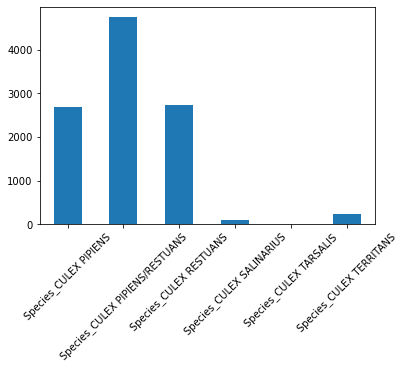

In [90]:
species_caught = df.loc[:,'Species_CULEX PIPIENS':'Species_CULEX TERRITANS'].sum()
species_caught.plot.bar(x=species_caught.index,y=species_caught.values,rot=45)

In [91]:
virus = df[df['WnvPresent'] == 1]
no_virus = df[df['WnvPresent'] == 0]

In [92]:
# Of the mosquitos caught with the virus, what species contained the virus?
# Interesting, only some of the species contained the virus!

<AxesSubplot:>

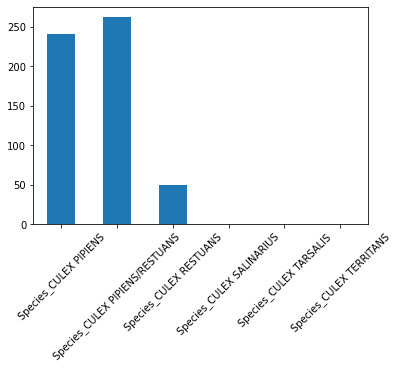

In [93]:
species_count = virus.loc[:,'Species_CULEX PIPIENS':'Species_CULEX TERRITANS'].sum()
species_count.plot.bar(x=species_count.index,y=species_count.values,rot=45)

In [94]:
# Now let's see what blocks contained the most mosquitos with West Nile Virus.

Text(0, 0.5, 'Number of Infected Mosquitos')

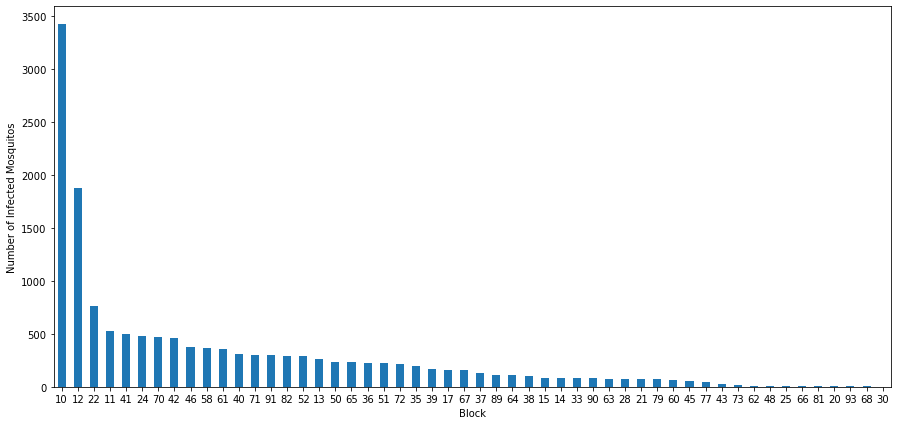

In [95]:
block_group = virus.groupby('Block').sum()
block_count = block_group['NumMosquitos'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,7))
block_count.plot.bar(block_count.index,block_count.values, rot=0)
plt.xlabel('Block')
plt.ylabel('Number of Infected Mosquitos')

In [ ]:
# Here we can clearly see block 10 has a significant percntage of all virus carrying mosquitos. Block 12 also 
# makes up a considerable amount of the infected mosquitos.

In [ ]:
# Let's quickly calulate the number of infected mosquitos from block 10 and 12.

In [58]:
num_block_10 = block_count.loc[10]
num_all = block_count.sum()
percent_block_10 = round(num_block_10/num_all *100,2)
print(f'{percent_block_10}% of infected mosquitos came from block 10')

23.57% of infected mosquitos came from block 10


In [59]:
num_block_12 = block_count.loc[12]
num_all = block_count.sum()
percent_block_12 = round(num_block_12/num_all *100,2)
print(f'{percent_block_12}% of infected mosquitos came from block 12')

12.93% of infected mosquitos came from block 12


In [60]:
print(f'{round((num_block_10 + num_block_12)/num_all*100,2)}% of infected mosquitos came from block 10 and 12.')

36.5% of infected mosquitos came from block 10 and 12.


In [ ]:
# Now let's plot this data to a map with the size of the dots representing the total number of mosquitos caught.

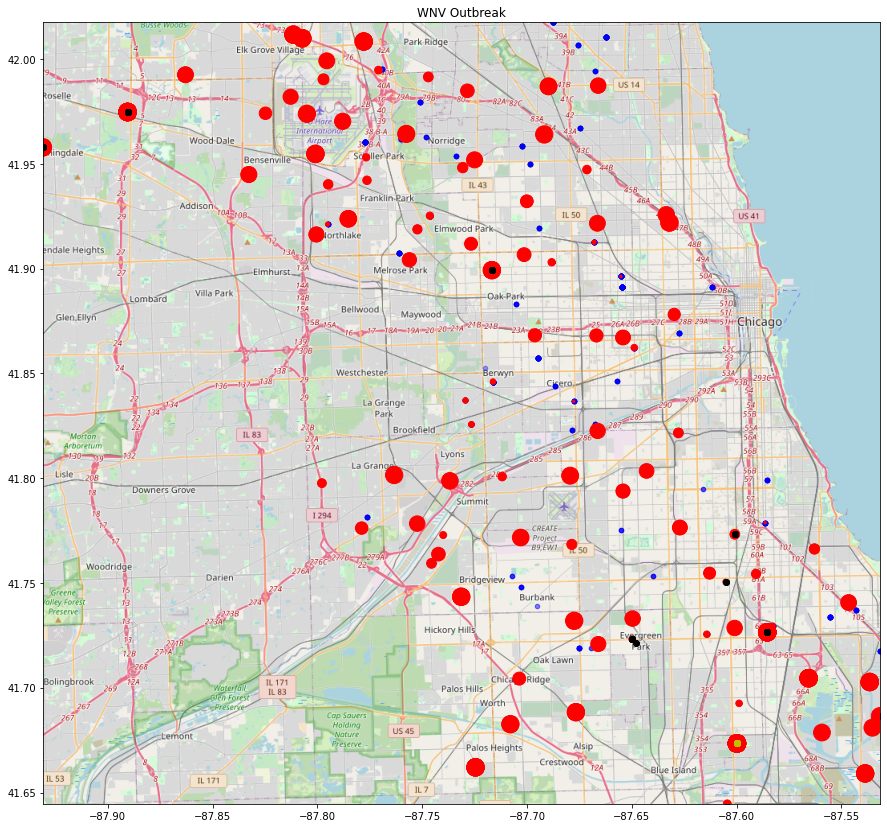

In [61]:
bbox = (df.Longitude.min(),  df.Longitude.max(),  df.Latitude.min(), df.Latitude.max())
mymap = plt.imread('/Users/Dreamscape/OneDrive - Springboard/Capstone 2/Images/map.png')

fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 0.2, c='b', s=20)
ax.scatter(virus.Longitude, virus.Latitude, zorder=1, alpha= 1, c='r', s=virus['NumMosquitos']*6)

ax.scatter(virus[virus.Block==10]['Longitude'],virus[virus.Block==10]['Latitude'],c='black')
ax.scatter(virus[virus.Block==12]['Longitude'],virus[virus.Block==12]['Latitude'],c='y')


ax.set_title('WNV Outbreak')
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.imshow(mymap, zorder=0, extent = bbox, aspect= 'equal')

In [ ]:
# This latitude and longitude analysis shows that the virus was detected fairly evenly across the city with only 
# a few traps highlighted in blue that did not have any west nile virus detected.
# The Block 10 data seems to be incorrect as there are a number of different locations in black that indicate 
# they are part of block 10. Perhaps this is why this column had so many more infected mosquitos than the other blocks.

In [ ]:
# Let's split the Block 10 data into separate values for each latitude and longitude combination.

In [62]:
block_10 = df[df.Block==10].groupby(['Latitude','Longitude']).size()

In [63]:
block_10.index

MultiIndex([(         41.721474,         -87.648064),
            (41.723195000000004,          -87.64997),
            (41.726465000000005,         -87.585413),
            (         41.750498,         -87.605294),
            (         41.773215,          -87.60088),
            (         41.869107, -87.69629300000001),
            (41.899229999999996,         -87.716788),
            (         41.957799,         -87.930995),
            (         41.974689,         -87.890615)],
           names=['Latitude', 'Longitude'])

In [64]:
block_num = 100

for location in block_10.index:
    df.loc[(df['Latitude'] == location[0])&(df['Longitude'] == location[1]),'Block'] = block_num
    block_num += 1


In [ ]:
# Now each value in Block 10 is renamed appropriately.

In [65]:
df[df['Block']>=100]['Block'].value_counts()

108    750
102    314
107    140
104    128
106    126
103    112
101     91
100     33
105     28
Name: Block, dtype: int64

In [66]:
virus = df[df['WnvPresent'] == 1]
no_virus = df[df['WnvPresent'] == 0]

In [ ]:
# Let's look at the Block breakdown again.

Text(0, 0.5, 'Number of Infected Mosquitos')

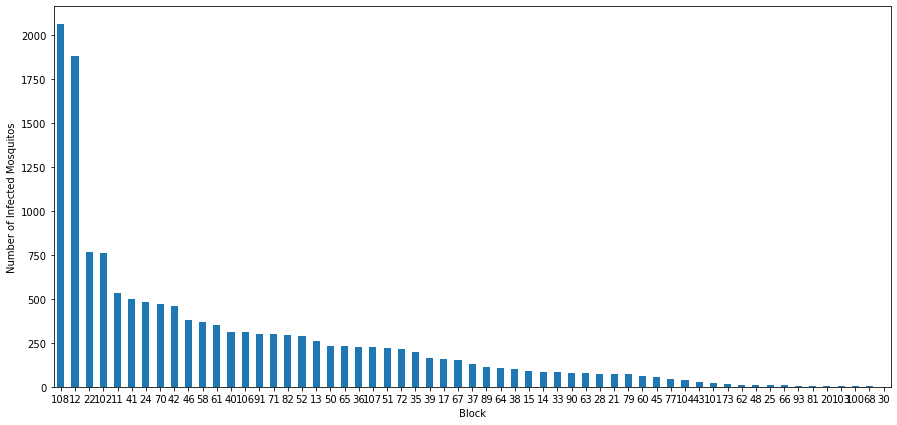

In [67]:
block_group = virus.groupby('Block').sum()
block_count = block_group['NumMosquitos'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,7))
block_count.plot.bar(block_count.index,block_count.values, rot=0)
plt.xlabel('Block')
plt.ylabel('Number of Infected Mosquitos')

In [68]:
# Now with the chart above the blocks accurately showcase areas that have the most infected mosquitos

In [69]:
virus[virus.Block==108][['Latitude','Longitude']].value_counts()

Latitude   Longitude 
41.974689  -87.890615    66
dtype: int64

In [70]:
# The location of Block 12 is very close to the O'Hare International Airport after looking on Google Maps.

In [71]:
virus[virus.Block==12][['Latitude','Longitude']].value_counts()

Latitude   Longitude 
41.673408  -87.599862    41
dtype: int64

In [72]:
# And Block 108 is at Lake Calumet and close to Big Marsh Park and Calumet Water Reclamation Plant (standing water)

In [73]:
num_block_108 = block_count.loc[108]
num_all = block_count.sum()
percent_block_108 = round(num_block_108/num_all *100,2)
print(f'{percent_block_108}% of infected mosquitos came from block 108')

14.19% of infected mosquitos came from block 108


In [74]:
num_block_12 = block_count.loc[12]
num_all = block_count.sum()
percent_block_12 = round(num_block_12/num_all *100,2)
print(f'{percent_block_12}% of infected mosquitos came from block 12')

12.93% of infected mosquitos came from block 12


In [ ]:
# It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

In [76]:
print('Average temperature when no virus is present: ' + str(round(no_virus.Tavg.mean(),2)))
print('Average temperature when virus present: ' + str(round(virus.Tavg.mean(),2)))

Average temperature when no virus is present: 73.08
Average temperature when virus present: 75.1


In [77]:
print('Average precipitation when no virus is present: ' + str(round(no_virus.PrecipTotal.mean(),2)))
print('Average precipitation when virus is present: ' + str(round(virus.PrecipTotal.mean(),2)))

Average precipitation when no virus is present: 0.14
Average precipitation when virus is present: 0.17


In [ ]:
# This quick analysis shows us that when the virus is present hot and wet conditions are more favorable

In [ ]:
# Now let's see which month contained the most mosquitos caught with West Nile Virus.

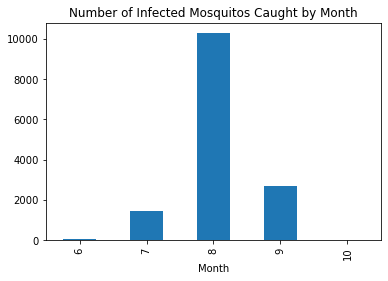

In [78]:
virus_month = virus.groupby('Month')['NumMosquitos'].sum()
virus_month.plot.bar(virus_month.index,virus_month.values)
plt.title('Number of Infected Mosquitos Caught by Month')
plt.show()

In [ ]:
# Wow, August contains over 70% of the infected mosquitos! 

In [79]:
num_aug = virus_month.loc[8]
total_month = virus_month.sum()
print(f'{round(num_aug / total_month * 100,2)}% of mosquitos with the virus were caught in August.')

70.87% of mosquitos with the virus were caught in August.


In [ ]:
# Now finally let's visualize how Total Precipitation correlates with the number of infected mosquitos caught.

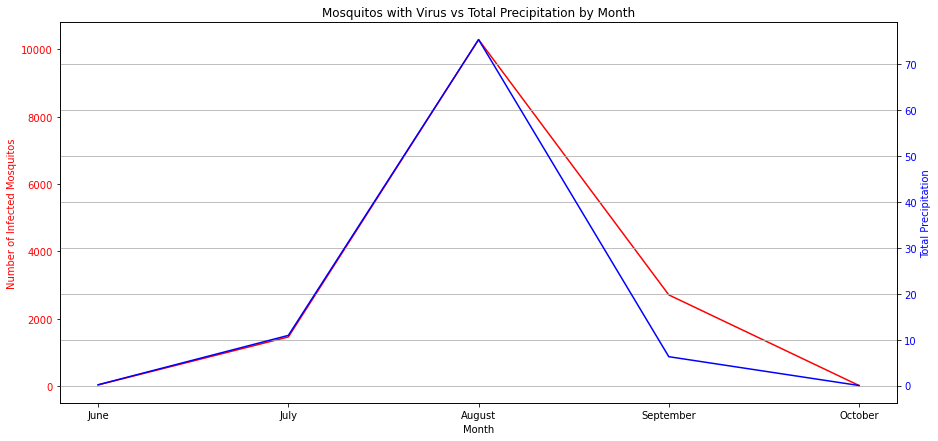

In [173]:
fig, ax1 = plt.subplots(figsize=(15,7))

count_virus = virus.groupby('Month').sum()['NumMosquitos']
temp = virus.groupby('Month').sum()['PrecipTotal']

color='red'
ax1.plot(count_virus.index, count_virus.values,color=color)
ax1.set_ylabel('Number of Infected Mosquitos',color=color)
ax1.set_xlabel('Month',color='k')

ax1.tick_params(axis='y', labelcolor=color)
plt.xticks([6, 7, 8, 9, 10], ['June', 'July', 'August','September','October'], rotation=0)

ax2 = ax1.twinx()

color='blue'
ax2.plot(temp.index,temp.values,color=color)
ax2.set_ylabel('Total Precipitation',color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Mosquitos with Virus vs Total Precipitation by Month')
plt.grid()

In [ ]:
# And let's compare the same for Depart (how far the temperature is from the 30 year average)

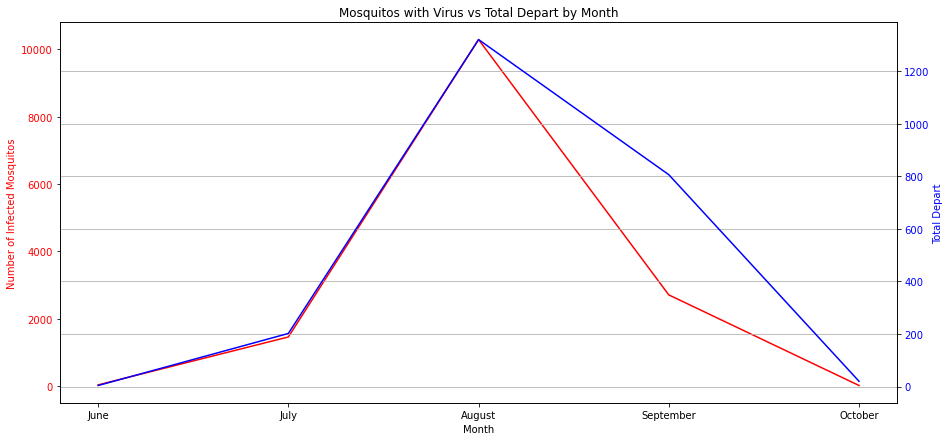

In [174]:
fig, ax1 = plt.subplots(figsize=(15,7))

count_virus = virus.groupby('Month').sum()['NumMosquitos']
temp = virus.groupby('Month').sum()['Depart']

color='red'
ax1.plot(count_virus.index, count_virus.values,color=color)
ax1.set_ylabel('Number of Infected Mosquitos',color=color)
ax1.set_xlabel('Month',color='k')

ax1.tick_params(axis='y', labelcolor=color)
plt.xticks([6, 7, 8, 9, 10], ['June', 'July', 'August','September','October'], rotation=0)

ax2 = ax1.twinx()

color='blue'
ax2.plot(temp.index,temp.values,color=color)
ax2.set_ylabel('Total Depart',color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.title('Mosquitos with Virus vs Total Depart by Month')
plt.grid()

In [ ]:
# Clearly an increased amount of precipitation and higher temperature (positive departure) correlates with 
# mosquitos being caught with West Nile Virus!

In [ ]:
# Let's also plot the data to box plots to make sure there are no dramadic outliers. Looks good!

In [85]:
odf = df.loc[:,'NumMosquitos':'AvgSpeed']
odf = odf.drop(['Sunrise','Sunset', 'Species_CULEX PIPIENS','Species_CULEX PIPIENS/RESTUANS','Species_CULEX RESTUANS'], axis=1)

<AxesSubplot:>

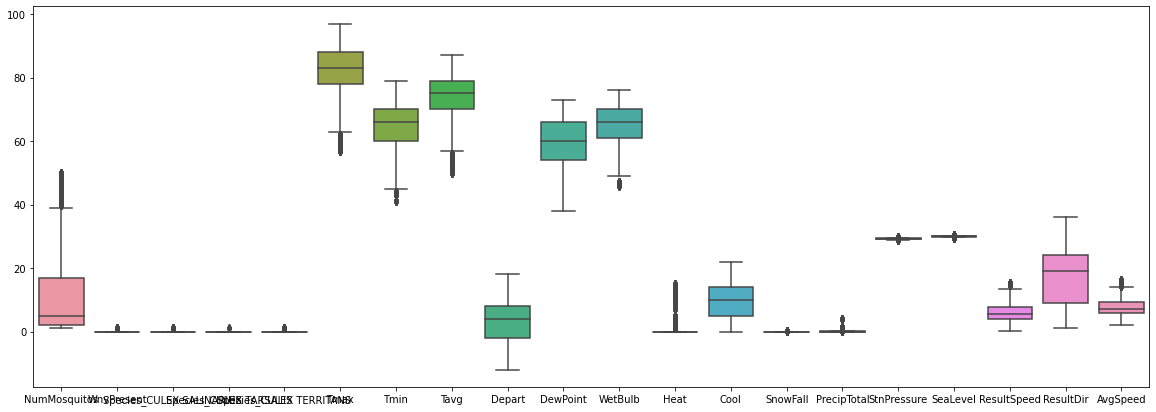

In [86]:
fig,ax = plt.subplots(figsize=(20,7))
sns.boxplot(data=odf)

In [93]:
# Based on the findings from earlier we will drop rows that contain species that do not contain any instances 
# of the virus.

In [94]:
df = df[(df['Species_CULEX SALINARIUS'] == 0)&(df['Species_CULEX TARSALIS'] == 0) & (df['Species_CULEX TERRITANS'] == 0)]

In [95]:
df = df.drop(['Species_CULEX SALINARIUS','Species_CULEX TARSALIS','Species_CULEX TERRITANS'],axis=1)

# Insights 

#### From out initial exploratory analysis we've identified:
- The only species to carry West Nile Virus in the dataset are Culex Pipiens and Culex Restuans.
- August contains over 70% of all West Nile Virus carrying mosquitos.
- Block 108 and 12 are where 27.11% of all infections were concentrated. 

#### Based on these findings here are a few actionable items:
- Spraying should start in late July and go through August. If there is a particular spray that better kills off the Culex Pipiens and Culex Restuans species this spray should be used.
- Block 108 and 12 should be target locations for extra intervention, both through extra spraying and educating the reseidents in that area on how they can stay safe. Perhaps suggesting they wear bug spray for all of the Summer months. 

# Alter Proportion of Target Variable

In [ ]:
# Next let's increase the proportion of rows with West Nile Virus. To do this we'll simply take a random sample of
# rows without the virus and take all the rows with the virus.

In [96]:
dfp = df[df.WnvPresent==1]
dfm = df[df.WnvPresent==0]

In [97]:
print(dfp.shape)
print(dfm.shape)

(551, 162)
(9641, 162)


In [ ]:
# I'd like to get there to be abot 20% rows with the virus so lets do some arithmatic to find how many rows we'll need.

In [98]:
size = 551/.2

In [99]:
size

2755.0

In [ ]:
# And let's take a random sample of non virus rows of that size, and append all the virus data.

In [100]:
dfm = dfm.sample(n = 2755) 

In [101]:
df = dfp.append(dfm)

In [102]:
df

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Trange,Rain,Mist,TSRA,Haze,Drizzle,Thunderstorm,Local_TS,Tmax_lag1.0,Tmin_lag1.0,Tavg_lag1.0,Depart_lag1.0,DewPoint_lag1.0,WetBulb_lag1.0,Heat_lag1.0,Cool_lag1.0,Sunrise_lag1.0,Sunset_lag1.0,SnowFall_lag1.0,PrecipTotal_lag1.0,StnPressure_lag1.0,SeaLevel_lag1.0,ResultSpeed_lag1.0,ResultDir_lag1.0,AvgSpeed_lag1.0,Trange_lag1.0,Rain_lag1.0,Mist_lag1.0,TSRA_lag1.0,Haze_lag1.0,Drizzle_lag1.0,Thunderstorm_lag1.0,Local_TS_lag1.0,Tmax_lag2.0,Tmin_lag2.0,Tavg_lag2.0,Depart_lag2.0,DewPoint_lag2.0,WetBulb_lag2.0,Heat_lag2.0,Cool_lag2.0,Sunrise_lag2.0,Sunset_lag2.0,SnowFall_lag2.0,PrecipTotal_lag2.0,StnPressure_lag2.0,SeaLevel_lag2.0,ResultSpeed_lag2.0,ResultDir_lag2.0,AvgSpeed_lag2.0,Trange_lag2.0,Rain_lag2.0,Mist_lag2.0,TSRA_lag2.0,Haze_lag2.0,Drizzle_lag2.0,Thunderstorm_lag2.0,Local_TS_lag2.0,Tmax_lag3.0,Tmin_lag3.0,Tavg_lag3.0,Depart_lag3.0,DewPoint_lag3.0,WetBulb_lag3.0,Heat_lag3.0,Cool_lag3.0,Sunrise_lag3.0,Sunset_lag3.0,SnowFall_lag3.0,PrecipTotal_lag3.0,StnPressure_lag3.0,SeaLevel_lag3.0,ResultSpeed_lag3.0,ResultDir_lag3.0,AvgSpeed_lag3.0,Trange_lag3.0,Rain_lag3.0,Mist_lag3.0,TSRA_lag3.0,Haze_lag3.0,Drizzle_lag3.0,Thunderstorm_lag3.0,Local_TS_lag3.0,Tmax_lag4.0,Tmin_lag4.0,Tavg_lag4.0,Depart_lag4.0,DewPoint_lag4.0,WetBulb_lag4.0,Heat_lag4.0,Cool_lag4.0,Sunrise_lag4.0,Sunset_lag4.0,SnowFall_lag4.0,PrecipTotal_lag4.0,StnPressure_lag4.0,SeaLevel_lag4.0,ResultSpeed_lag4.0,ResultDir_lag4.0,AvgSpeed_lag4.0,Trange_lag4.0,Rain_lag4.0,Mist_lag4.0,TSRA_lag4.0,Haze_lag4.0,Drizzle_lag4.0,Thunderstorm_lag4.0,Local_TS_lag4.0,Tmax_lag5.0,Tmin_lag5.0,Tavg_lag5.0,Depart_lag5.0,DewPoint_lag5.0,WetBulb_lag5.0,Heat_lag5.0,Cool_lag5.0,Sunrise_lag5.0,Sunset_lag5.0,SnowFall_lag5.0,PrecipTotal_lag5.0,StnPressure_lag5.0,SeaLevel_lag5.0,ResultSpeed_lag5.0,ResultDir_lag5.0,AvgSpeed_lag5.0,Trange_lag5.0,Rain_lag5.0,Mist_lag5.0,TSRA_lag5.0,Haze_lag5.0,Drizzle_lag5.0,Thunderstorm_lag5.0,Local_TS_lag5.0,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-18,38,41.686398,-87.531635,8,50,1,0,1,0,85.0,69.0,77.0,3.0,69.0,71.0,0.0,12.0,432.0,1924.0,0.0,0.920,29.18,29.83,10.3,24.0,10.6,16.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,83.0,69.0,76.0,2.0,65.0,69.0,0.0,11.0,431.0,1925.0,0.0,0.110,29.24,29.89,6.3,23.0,7.4,14.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,82.0,66.0,74.0,0.0,60.0,65.0,0.0,9.0,430.0,1925.0,0.0,0.07,29.31,29.94,5.6,23.0,6.6,16.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,80.0,64.0,72.0,-3.0,52.0,61.000000,0.0,7.0,429.0,1926.0,0.0,0.00,29.25,29.88,1.2,9.0,6.5,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,62.0,74.0,0.0,55.0,62.0,0.0,9.0,428.0,1927.0,0.0,0.000,29.14,29.79,8.4,25.0,13.9,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,59.0,67.0,-5.0,53.0,59.0,0.0,2.0,428.0,1927.0,0.0,0.00,29.330000,29.98,2.0,7.0,5.8,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007,7,18
2007-07-25,12,41.673408,-87.599862,5,50,1,0,1,0,83.0,70.0,77.0,4.0,60.0,66.0,0.0,12.0,438.0,1918.0,0.0,0.000,29.35,29.99,6.4,23.0,7.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,65.0,74.0,0.0,57.0,64.0,0.0,9.0,437.0,1919.0,0.0,0.005,29.38,30.03,1.1,21.0,4.9,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,63.0,73.0,-2.0,55.0,63.0,0.0,8.0,436.0,1920.0,0.0,0.00,29.42,30.09,2.9,12.0,3.9,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,61.0,71.0,-4.0,54.0,61.000000,0.0,6.0,435.0,1921.0,0.0,0.00,29.54,30.20,1.9,18.0,3.5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,58.0,67.0,-8.0,52.0,59.0,0.0,2.0,434.0,1922.0,0.0,0.000,29.57,30.21,5.8,4.0,7.4,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,62.0,68.0,-7.0,52.0,59.0,0.0,3.0,433.0,1923.0,0.0,0.00,29.490000,30.12,11.3,4.0,11.5,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007,7,25
2007-07-25,12,41.673408,-87.599862,5,50,1,0,1,0,83.0,70.0,77.0,4.0,60.0,66.0,0.0,12

# Attribute Relevance Analysis

In [ ]:
# Next let's split the data with train test split and find which segment of each feature has the strongest connection 
# with the target variable. The remaining features will be selected as best candidates for building our predictive model.

In [103]:
x = df.drop(['WnvPresent'],axis=1)
y = df['WnvPresent']

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=2)

In [105]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [106]:
final_iv, IV = data_vars(x_train, y_train)

/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Dreamscape/opt/anaconda3/lib/python3.8/site

In [107]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
x_train = x_train[features]

# Remove Features with High Correlation

In [ ]:
# Next we'll remove any remaining features that are highly correlated with one another.

In [108]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(x_train)

Iteration # 1


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tmax_lag1.0 with VIF of inf
Iteration # 2


/Users/Dreamscape/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing Tmax_lag4.0 with VIF of inf
Iteration # 3
Removing Tavg_lag1.0 with VIF of 8504015.509030
Iteration # 4
Removing SeaLevel_lag3.0 with VIF of 11607420.324655
Iteration # 5
Removing Sunrise_lag2.0 with VIF of 8593304.258938
Iteration # 6
Removing SeaLevel_lag4.0 with VIF of 7633995.948936
Iteration # 7
Removing Sunrise_lag5.0 with VIF of 6388844.691760
Iteration # 8
Removing SeaLevel_lag1.0 with VIF of 5401646.673307
Iteration # 9
Removing StnPressure_lag5.0 with VIF of 3021321.517809
Iteration # 10
Removing Longitude with VIF of 1652633.409373
Iteration # 11
Removing Sunset_lag1.0 with VIF of 1387356.469926
Iteration # 12
Removing Year with VIF of 967939.616501
Iteration # 13
Removing StnPressure_lag4.0 with VIF of 741130.690051
Iteration # 14
Removing Sunset_lag3.0 with VIF of 702862.316066
Iteration # 15
Removing Sunset_lag2.0 with VIF of 519924.628675
Iteration # 16
Removing Tavg_lag2.0 with VIF of 366940.397964
Iteration # 17
Removing StnPressure_lag1.0 with VIF of 303875.5

In [109]:
x_train = final_df

In [110]:
x_test = x_test[x_train.columns]

# Model Selection

In [ ]:
# Now we're ready to build our model! First step, figure out what classification model will perform best. Let's
# run some models with their default settings and compate results.

### Null Accuracy

In [ ]:
# If we were to choose all 0's for the target variable (no West Nile Virus) how accurate would our model be?

In [112]:
# We can see the class distribution is very uneven. Because of this Accuracy will not be a sufficient metric 
# for model selection.
y.value_counts()

0    2755
1     551
Name: WnvPresent, dtype: int64

In [113]:
# Here we can see if we were to choose 0 for all predictions we would have an 83.33% accuracy.
print('Null Accuracy: '+ str(1-y.mean()))

Null Accuracy: 0.8333333333333334


### KNN

In [ ]:
# For KNN I'm first going to find better default parameters.

#### Improving default parameters

In [ ]:
# Let's test n_neighbors between 40 and 50 with two of the most frequent weight options.

In [114]:
k_range = range(40,50)
weight_options = ['uniform', 'distance']
knn = KNeighborsClassifier()

param_grid = dict(n_neighbors=k_range, weights=weight_options)

In [115]:
grid = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_iter=20)

In [116]:
grid.fit(x_train,y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'n_neighbors': range(40, 50),
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [117]:
print(grid.best_score_)
print(grid.best_params_)

0.8343310463121785
{'weights': 'distance', 'n_neighbors': 42}


#### Fitting model with found parameters

In [ ]:
# Now let's fit the model with the parameters we found above.

In [118]:
best_n = grid.best_params_['n_neighbors']
best_w = grid.best_params_['weights']

knn = KNeighborsClassifier(n_neighbors=best_n,weights=best_w)
knn.fit(x_train,y_train)

knn_y_pred = knn.predict(x_test)
predictions = [round(value) for value in knn_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.99%


#### Understanding Variable Importance

In [119]:
# Unfortunately SHAP doesn't support KNN model

### Logistic Regression

In [ ]:
# Next let's run a logistic regression

In [120]:
logreg=LogisticRegression(solver='liblinear')
logreg.fit(x_train,y_train)

log_y_pred = logreg.predict(x_test)
predictions = [round(value) for value in log_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.69%


In [121]:
# SHAP also doesn't work for Logistic Regression

### XGB

In [ ]:
# Next let's check XGB

In [122]:
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

xgb_y_pred = xgb.predict(x_test)
predictions = [round(value) for value in xgb_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.93%


In [123]:
# Link to workaround for XGB and SHAP 
# https://github.com/slundberg/shap/issues/1215

In [ ]:
# Let's find the features that were important in predicting this model with SHAP values.

In [124]:
mybooster = xgb.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


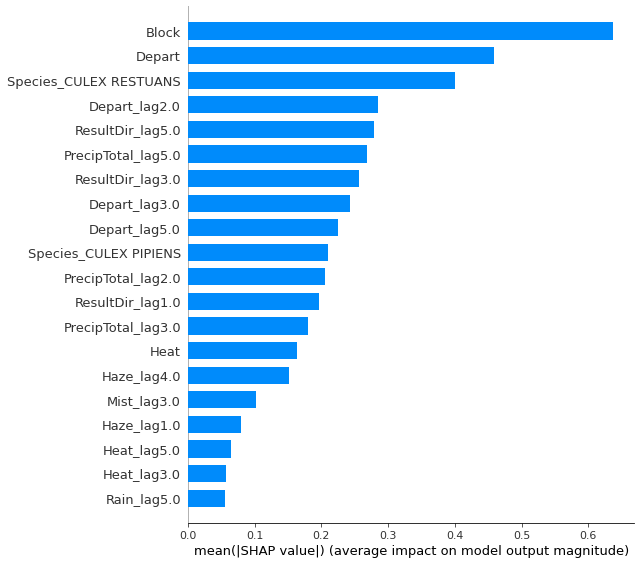

In [125]:
shap_values = shap_ex.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

### Random Forrest

In [ ]:
# And finally let's build a RandomForrest model as well.

In [126]:
randf = RandomForestClassifier(n_estimators=20, random_state=0)
randf.fit(x_train,y_train)

randf_y_pred = randf.predict(x_test)
predictions = [round(value) for value in randf_y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 81.57%


#### Using Shap to understand variable importance in RandomForrest model

In [ ]:
# And see what features are important.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


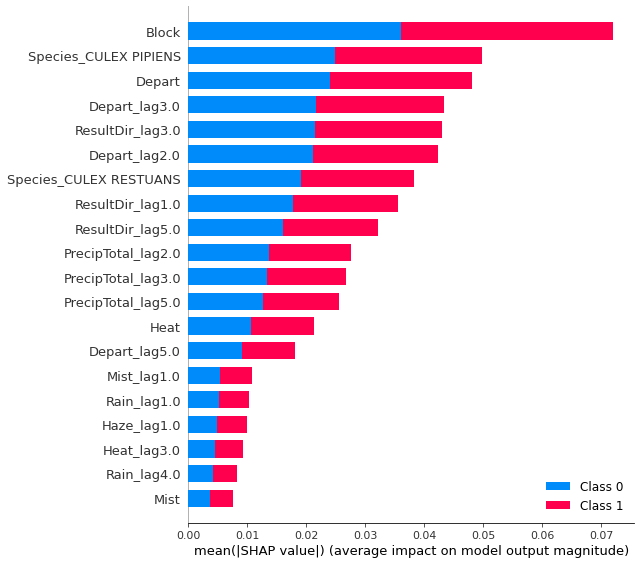

In [127]:
shap_values = shap.TreeExplainer(randf).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

# Comparing Models with AUC / ROC curve

In [ ]:
# Now that we've built the models, we can assess which one is best by looking at the ROC curve and AUC score.

In [128]:
base_prob = [0 for _ in range(len(y_test))]
knn_prob = knn.predict_proba(x_test)[:,1]
log_prob = logreg.predict_proba(x_test)[:,1]
xgb_prob = xgb.predict_proba(x_test)[:,1]
randf_prob = randf.predict_proba(x_test)[:,1]

In [ ]:
# Let's find the ROC score for the probability results for each model.

In [130]:
base_auc = roc_auc_score(y_test,base_prob)
knn_auc = roc_auc_score(y_test,knn_prob)
log_auc = roc_auc_score(y_test,log_prob)
xgb_auc = roc_auc_score(y_test,xgb_prob)
randf_auc = roc_auc_score(y_test,randf_prob)

In [131]:
print('Base AUC = %.4f'%(base_auc))
print('KNeighborClassifier AUC = %.4f'%(knn_auc))
print('Logistic Regression AUC = %.4f'%(log_auc))
print('XGBoost AUC = %.4f'%(xgb_auc))
print('RandomForest AUC = %.4f'%(knn_auc))

Base AUC = 0.5000
KNeighborClassifier AUC = 0.6759
Logistic Regression AUC = 0.7485
XGBoost AUC = 0.7919
RandomForest AUC = 0.6759


In [ ]:
# Now lets get the false positive rate and true positive rate so we can plot this on a chart.

In [132]:
base_fpr, base_tpr, _ = roc_curve(y_test,base_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test,knn_prob)
log_fpr, log_tpr, _ = roc_curve(y_test,log_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test,xgb_prob)
randf_fpr, randf_tpr, _ = roc_curve(y_test,randf_prob)

In [ ]:
# Now we'll plot these results on the same chart and include the scores in the legend.

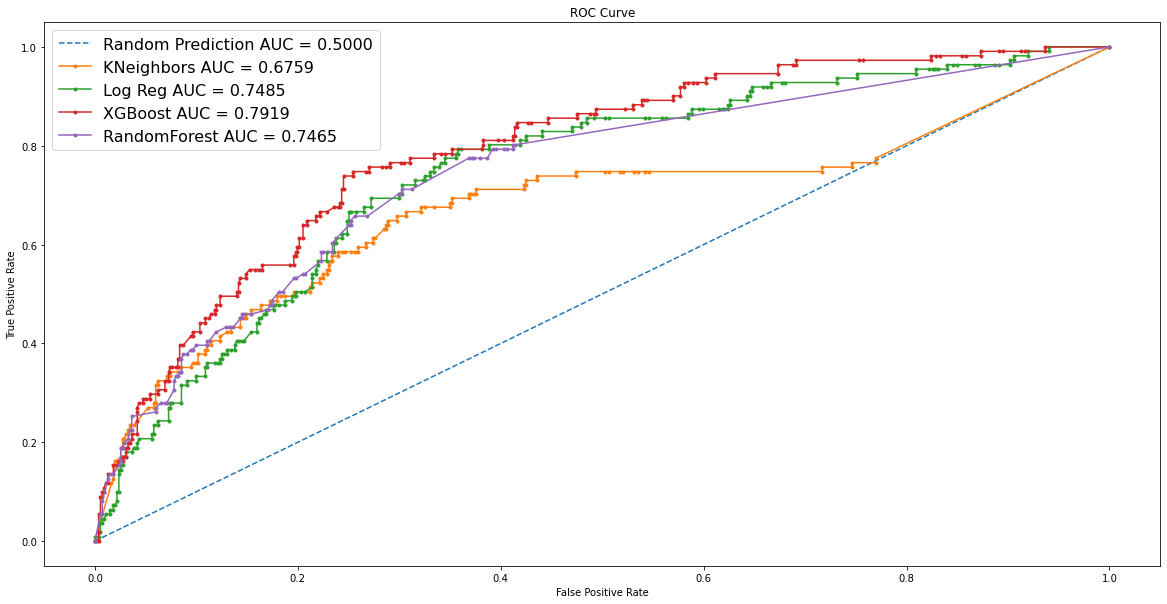

In [133]:
plt.subplots(figsize=(20,10))

plt.plot(base_fpr, base_tpr, linestyle='--', label='Random Prediction AUC = %.4f'% base_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNeighbors AUC = %.4f'% knn_auc)
plt.plot(log_fpr, log_tpr, marker='.', label='Log Reg AUC = %.4f'% log_auc)
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost AUC = %.4f'% xgb_auc)
plt.plot(randf_fpr, randf_tpr, marker='.', label='RandomForest AUC = %.4f'% randf_auc)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(prop={'size': 16})

In [ ]:
# Based on this score XGBoost is the best model to work with here.

# Precision-Recall Curve

In [ ]:
# Because we're working with data that has an unequal distribution of classes we'd also like to plot a precision
# recall curve to assess model results.

KNN: f1=0.329 auc=0.397
Log: f1=0.239 auc=0.362
XGB: f1=0.438 auc=0.431
RandF: f1=0.419 auc=0.416


Text(0.5, 1.0, 'Precision Curve')

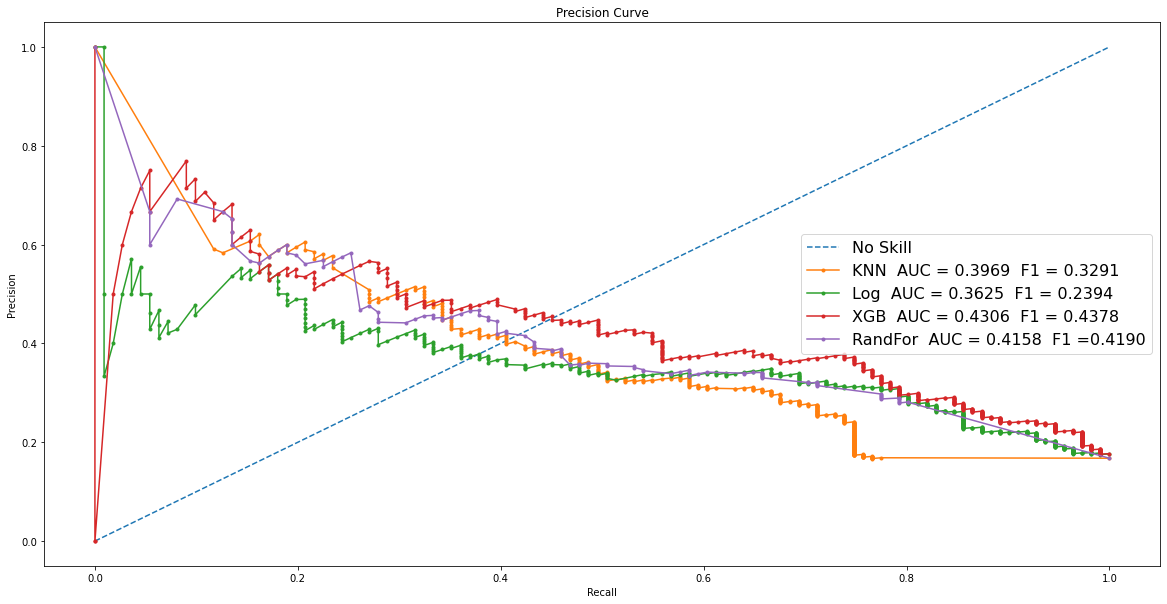

In [135]:
plt.subplots(figsize=(20,10))

knn_precision, knn_recall, _ = precision_recall_curve(y_test, knn_prob)
log_precision, log_recall, _ = precision_recall_curve(y_test, log_prob)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_prob)
randf_precision, randf_recall, _ = precision_recall_curve(y_test, randf_prob)

knn_f1, knn_auc = f1_score(y_test, knn_y_pred), auc(knn_recall, knn_precision)
log_f1, log_auc = f1_score(y_test, log_y_pred), auc(log_recall, log_precision)
xgb_f1, xgb_auc = f1_score(y_test, xgb_y_pred), auc(xgb_recall, xgb_precision)
randf_f1, randf_auc = f1_score(y_test, randf_y_pred), auc(randf_recall, randf_precision)

print('KNN: f1=%.3f auc=%.3f' % (knn_f1, knn_auc))
print('Log: f1=%.3f auc=%.3f' % (log_f1, log_auc))
print('XGB: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
print('RandF: f1=%.3f auc=%.3f' % (randf_f1, randf_auc))


plt.plot(base_fpr, base_tpr, linestyle='--', label='No Skill')
plt.plot(knn_recall, knn_precision, marker='.', label='KNN  AUC = %.4f  F1 = %.4f'% (knn_auc, knn_f1))
plt.plot(log_recall, log_precision, marker='.', label='Log  AUC = %.4f  F1 = %.4f'% (log_auc, log_f1))
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB  AUC = %.4f  F1 = %.4f'% (xgb_auc, xgb_f1))
plt.plot(randf_recall, randf_precision, marker='.', label='RandFor  AUC = %.4f  F1 =%.4f' % (randf_auc, randf_f1))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(prop={'size': 16})
plt.title('Precision Curve')

In [ ]:
# Based on the AUC score and F1 score from the precision curve we can determine the XGBoost model to be the 
# best choice for this problem.

# Confusion Matrix

In [ ]:
# Let's take a quick look at the confusion matrix.

In [137]:
conf_mat = confusion_matrix(y_test, xgb_y_pred)
print(conf_mat)

[[505  46]
 [ 67  44]]


In [138]:
TN = conf_mat[0,0]
TP = conf_mat[1,1]
FP = conf_mat[0,1]
FN = conf_mat[1,0]

- Accuracy = TP + TN / TN + TP + FP + FN
- Precision / Positive Predictive Value = TP / TP + FP
- Sensativity / Recall / True Positive Rate = TP / TP + FN
- Specificity / True Negative Rate = TN / TN + FP

#### XGBoost

In [ ]:
# And let's look at the models scores all around up against RandomForrest (the next best model)

In [139]:
# Accuracy
from sklearn.metrics import accuracy_score
print(f'Accuracy score = {round(accuracy_score(y_test, xgb_y_pred),4)}')

# Recall
from sklearn.metrics import recall_score
print(f'Recall = {round(recall_score(y_test, xgb_y_pred, average=None)[0],4)}')

# Precision
from sklearn.metrics import precision_score
print(f'Precision score = {round(precision_score(y_test, xgb_y_pred, average=None)[0],4)}')

# F1
from sklearn.metrics import f1_score
print(f'F1 Score = {round(f1_score(y_test, xgb_y_pred, average=None)[1],4)}')


Accuracy score = 0.8293
Recall = 0.9165
Precision score = 0.8829
F1 Score = 0.4378


#### Random Forrest

In [140]:
print(f'Accuracy score = {accuracy_score(y_test, randf_y_pred)}')
print(f'Recall = {recall_score(y_test, randf_y_pred, average=None)}')
print(f'Precision score = {precision_score(y_test, randf_y_pred, average=None)[0]}')
print(f'F1 Score = {f1_score(y_test, randf_y_pred, average=None)}')

Accuracy score = 0.8157099697885196
Recall = [0.90018149 0.3963964 ]
Precision score = 0.8809946714031972
F1 Score = [0.89048474 0.41904762]


# Tuning Model

In [ ]:
# Finally we want to tune the model. 
# Ideally we'd minimize False Negatives - Predict no West Nile Virus when in fact there was West Nile Virus.
# A few False Positives are ok. - Predict West Nile Virus when there was no West Nile Virus. It's better to be safe 
# than sorry!

In [ ]:
# We're going to do a simple tuning with some default parameters below.

In [142]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [143]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [144]:
grid = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
# Now let's see what combination of parameters results in the best AUC score.

In [145]:
grid.fit(x_train,y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   23.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  7.9min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 10.2min finished


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=No

In [146]:
print(grid.best_score_)
print(grid.best_params_)

0.8296058954414569
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 180}


In [147]:
best_params = {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [148]:
xgb = XGBClassifier(learning_rate=0.1,max_depth=4,n_estimators=100)
xgb.fit(x_train,y_train)

xgb_y_pred = xgb.predict(x_test)

#### Rerunning Shap for best model

In [ ]:
# Finally let's run the SHAP scores for this model to understand what features were important.

In [149]:
mybooster = xgb.get_booster()

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


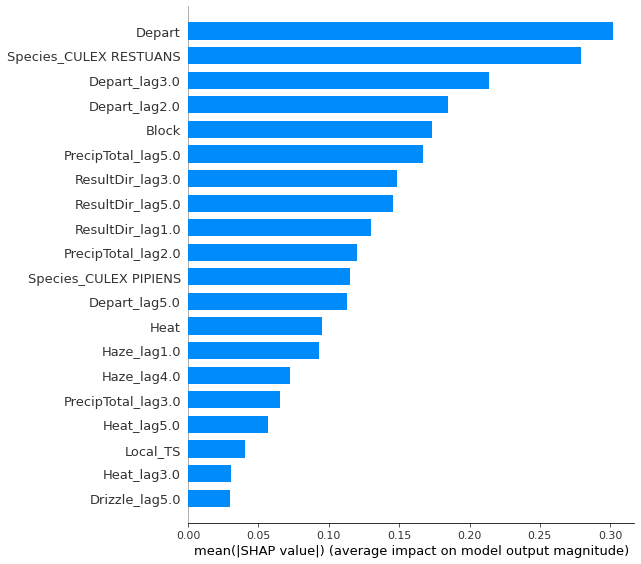

In [150]:
shap_values = shap_ex.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

### Analysis of SHAP values

- Depart plays the biggest role in predicting West Nile Virus, which makes sense because mosquitos thrive in the warmer weather and Depart indicates that the average temperatures were above or below the 30-year normal. Depart Lag2.0 and 3.0 is similar to Depart Lag except it is looking at the departure from normal from 2 and 3 days ago which signifies that the recent history of warmer weather could help mosquitos reproduce and spread West Nile Virus. 
- Species Culex Restuans is the next best predictor. This makes sense as it is one of the two species of Mosquitos caught with the virus. 
- PrecipTotal Lag5.0 indicates that the more precipitation there was 5 days ago then the more likely West Nile Virus will be present. This also makes sense as mosiquitos find a wetter environment more suitable for reproduction. The same goes for PrecipTotal Lag2.0 and Lag3.0. 
- ResultDir Lag1.0 indicates that the direction the wind is blowing one day prior has an impact predicting wnv. This is perhaps due to the wind blowing in the direction from a high concentration of mosquitos towards the traps / people. This is the same with ResultDir Lag3.0 and 5.0.
- Haze Lag1.0 indicates that if there was haze a day ago then it is more likely West Nile Virus is to be found which makes sense similarly to PrecipTotal as more moisture is benefitial for mosquito reproduction.



### Hypothesis

- There are two regions that are at higher risk of West Nile Virus outbreaks in Chicago. Both block 108 and 12. These are possibly hot spots because they are closer to standing water after rainfall.
- As the weather is warmer the risk for West Nile virus increases, especially when weather is warmer than the average of the last 30 years, because it allows mosquitos to reproduce more successfully. 
- Wind direction could play a factor in spreading West Nile Virus if it blows mosquitos toward standing water where they can reproduce more successfully.